# Introduction

Hello! This notebook is part of a project analyzing how the factors of composite Mersenne numbers behave (or how they're distributed).

Here, we are doing some fairly direct analysis of k-value races as we order them lexicographically by associated Mersenne p-value and then by size. This intro is under construction, but for those who would like to do some background reading I would suggest visiting [The Great Internet Mersenne Prime Search](https://www.mersenne.org) (aka GIMPS) and reading about prime number races. An excellent (if slightly old) introduction to the idea is available [here](https://dms.umontreal.ca/~andrew/PDF/PrimeRace.pdf) (and coauthored by my MA supervisor's supervisor, a little unsurprisingly).

# The Data

The main dataset with which I'm working is fairly large, and pulled from the GIMPS sister site [mersenne.ca](https://www.mersenne.ca). In particular, I'm using the (n,k) data from exponents n less than a billion (and in this notebook so far, considerably less than a million). I retrieved my version in June and the project is very active, so every few months the dataset is updated with richer information. What's lovely about this site is that the data it provides is generated by an active distributed computing project; many factors not even very far out would be hard or impossible to find alone.

In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Import the text data. Still sticking with 0G for now, it's plenty.

nkdata_raw = open('mersenneca_known_factors_0G.txt', 'r')

In [3]:
# Choices of adjustable things after file selection are here. Going with odd primes and 8 as moduli.

lines = 70000
mod_list = [3,5,7,11,13,17,8]

# Quick adjustment of if k and q parts are wanted.

qvals = True
kvals = True

In [4]:
# Read into a list first.

nkdata_raw.seek(0) # Just in case we messed around with the file somewhere before.

i = 0
nklist = []

# I'm going to get all the pairs without the newline at the end into a list, as strings.

for line in nkdata_raw:
    nklist.append(line[:(len(line)-1)])
    i=i+1
    if i == lines: # This is where we decide to stop. Don't blow up your computer.
        break

In [9]:
# k part

# Now we make our k lists of integers.

klist=[]

if kvals:
    for entry in nklist:
    
        # The entries are of the form 'n,k'. All we need is a simple split to get at the k value,
        # but in another section we'll look at n (which is to say p) values.
        
        stringk = entry.split(',')[1]
        k = int(stringk)
        klist.append(k)

    karray = np.asarray(klist) # put it in an array
    
    # Now we make our modded arrays and build the races.
    # How am I going to contain all the information on those races?
    
    # I'll build a dictionary of k arrays modded, and then a dictionary of races. The dictionaries will be indexed with the mods themselves.
    
    karrays_modded = {}
    
    for m in mod_list:
        karrays_modded[m]=(np.remainder(karray,m))

    # This will have, as its entries, the accumulation arrays of each mod.

    k_races = {} # dictionary of k_races, indexed by modulus m

    for m in mod_list: # current modulus
        
        this_race = [] # list of runs mod m
        
        for i in range(m): # residue in question
            
            this_race.append(np.zeros_like(karrays_modded[m])) # append the array which will be accumulation mod i

            s = 0 # The running sum; accumulation

            for index, e in np.ndenumerate(this_race[i]): # never ended up using e, this is likely quite inefficient. I'll fix it later.
                
                if karrays_modded[m][index] == i: # Checks if we're bumping up the count for this modulus
                    s = s+1
                this_race[i][index] = s # These will be what get graphed
        
        k_races[m] = this_race # the dictionary now has the race mod m indexed by m itself

In [5]:
# The races for q = 2kp+1. Basically as above but I don't know if I want to go through the trouble to avoid the code replication.

qlist = []

if qvals:
    for entry in nklist:

        # Build q; data are structured as they are above, but now we're using both parts of the nk string.

        nkstring = entry.split(',')
        n, k = int(nkstring[0]), int(nkstring[1])
        q = (2*n*k) + 1
        qlist.append(q)
        
    qarray = np.asarray(qlist) # put it in an array
    
    qarrays_modded = {}
    
    for m in mod_list:
        qarrays_modded[m]=(np.remainder(qarray,m))

    q_races = {}

    for m in mod_list:
        
        this_race = []
        
        for i in range(m):
            
            this_race.append(np.zeros_like(qarrays_modded[m]))

            s = 0

            for index, e in np.ndenumerate(this_race[i]):
                
                if qarrays_modded[m][index] == i:
                    s = s+1
                this_race[i][index] = s
        
        q_races[m] = this_race

# Graphs

We're now at a reasonable point for starting to look at what's happening.

## Line graphs with a few moduli

We start just graphing the races as they go. Nice for lower moduli, but we can appreciate roughly how the spread looks at higher values as well.

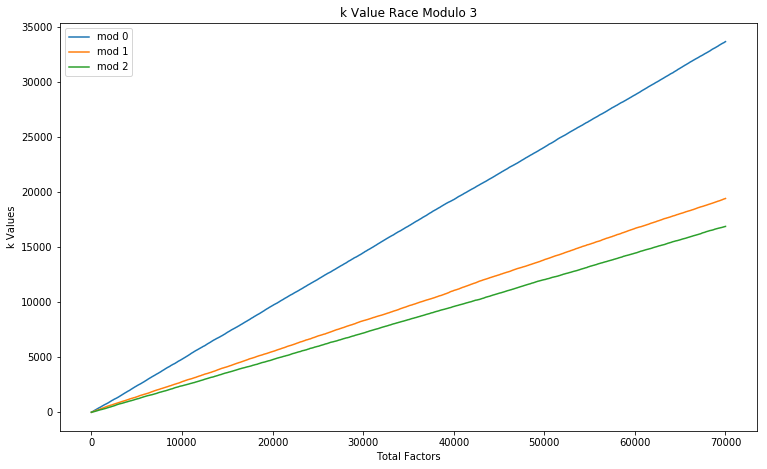

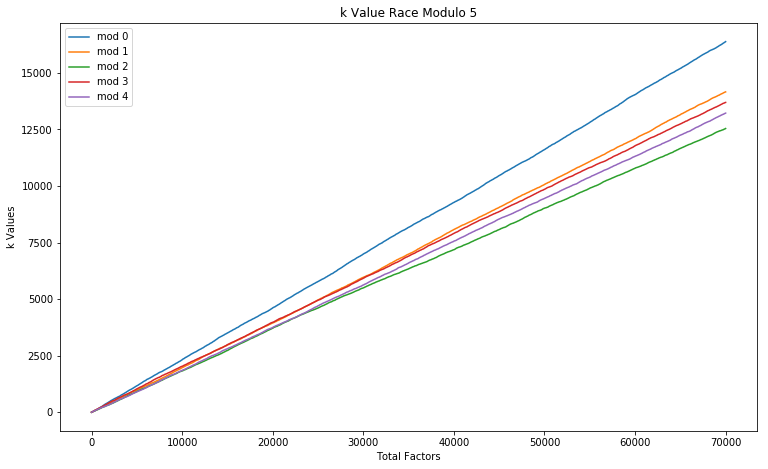

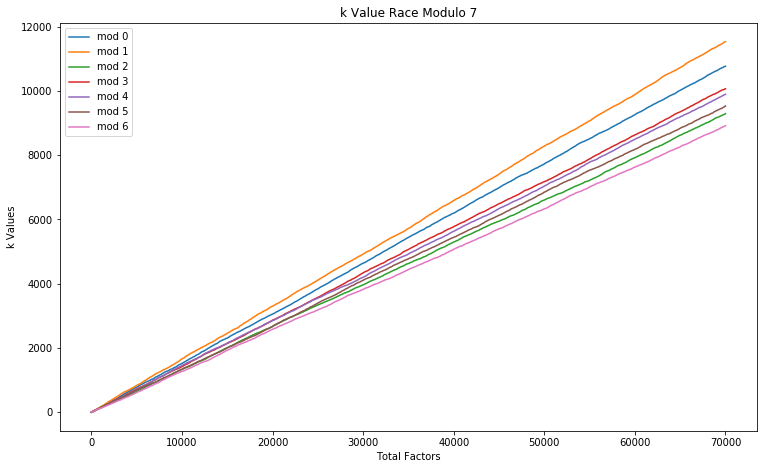

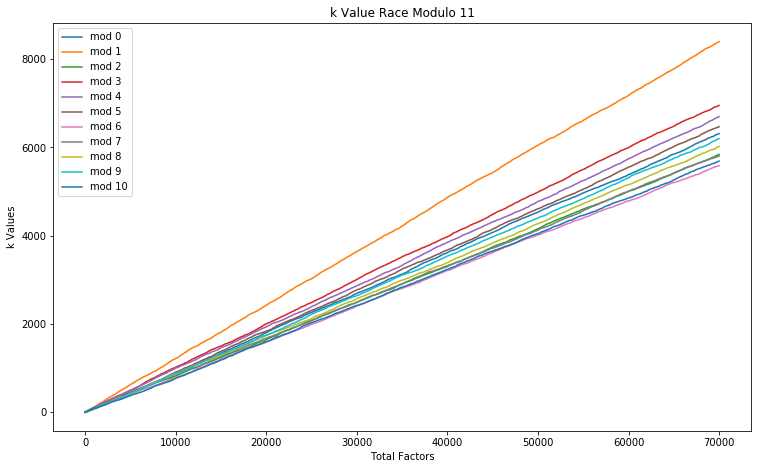

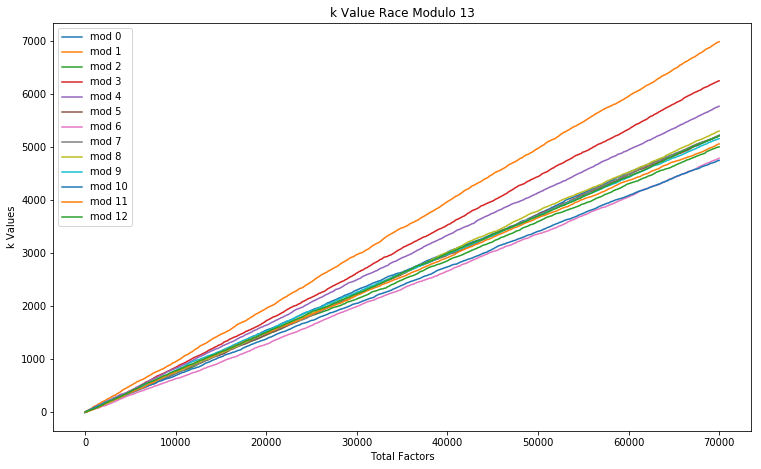

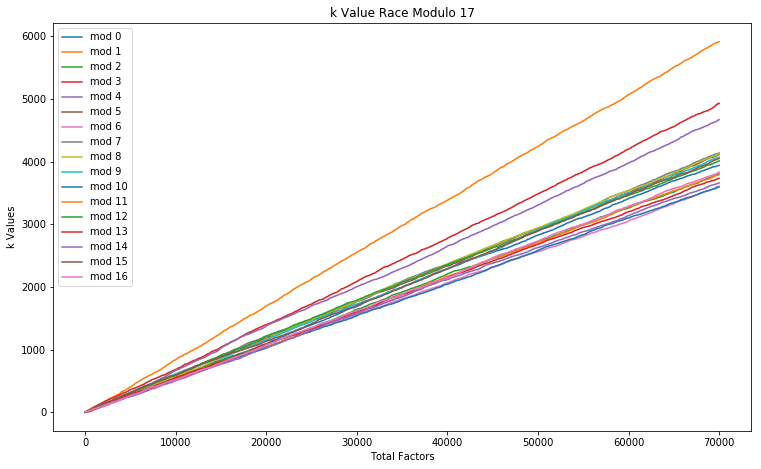

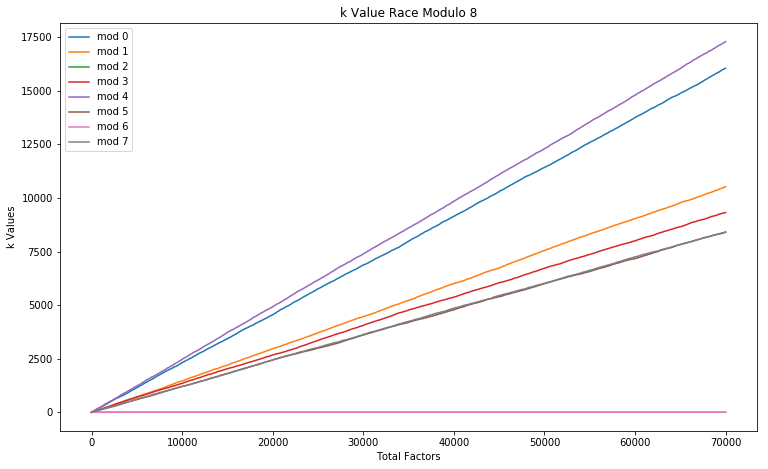

In [15]:
# Line graphs in k.

x = np.arange(len(karray)) + 1 # starting the x axis from 1, because I'm not a savage

for m in mod_list:    
    for i in range(m):
        plt.plot(x, k_races[m][i], label='mod ' + str(i))

    plt.xlabel('Total Factors')
    plt.ylabel('k Values')
    plt.title("k Value Race Modulo " + str(m))
    plt.legend()

    fig = plt.gcf()
    fig.set_size_inches(12.5, 7.5)

    plt.show()

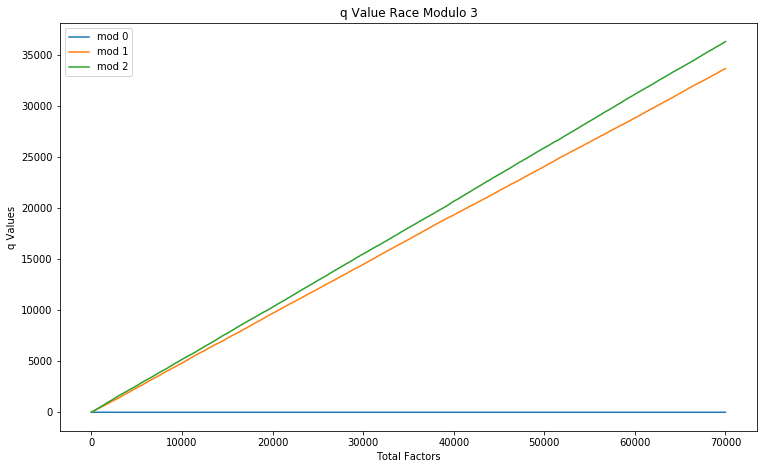

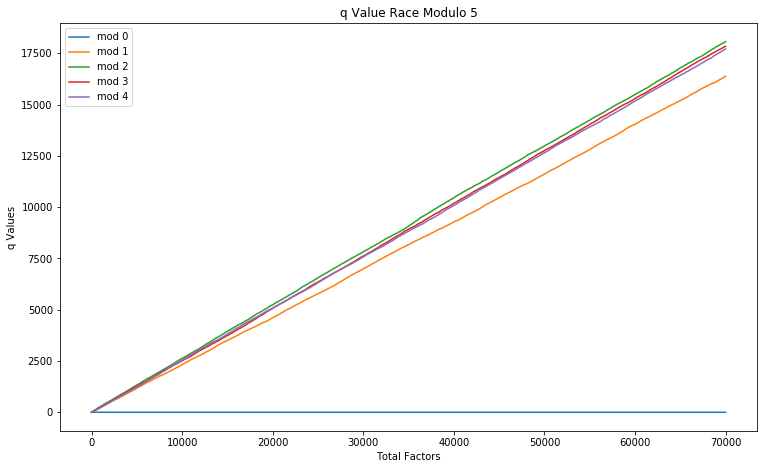

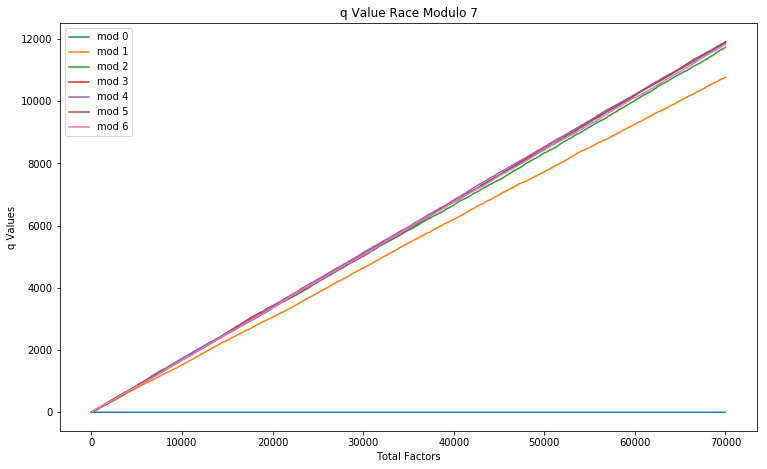

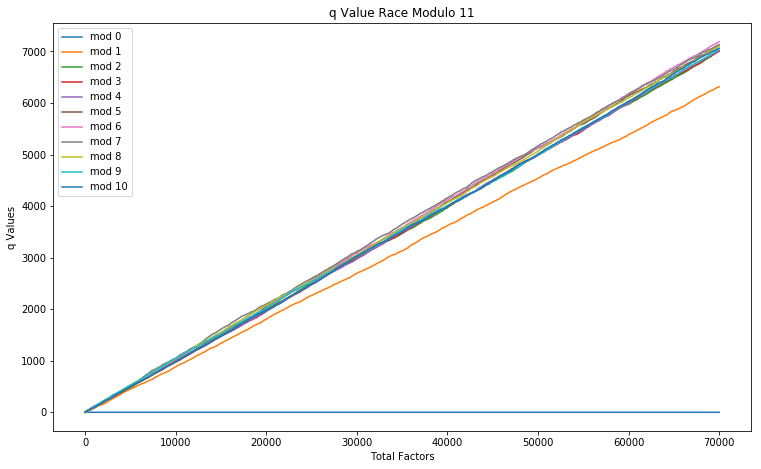

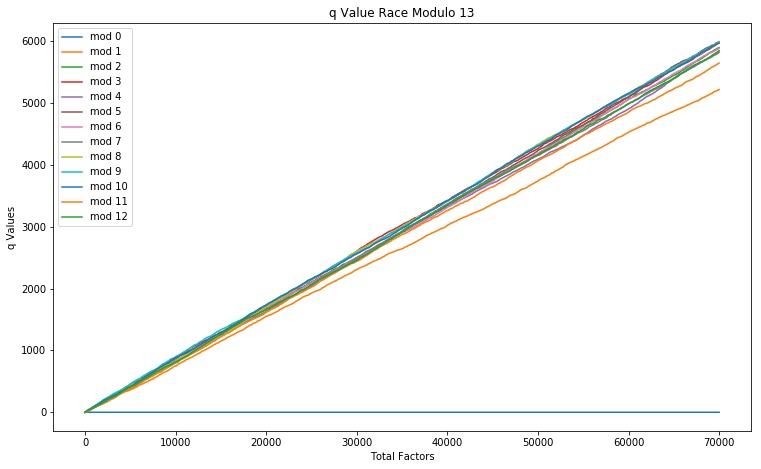

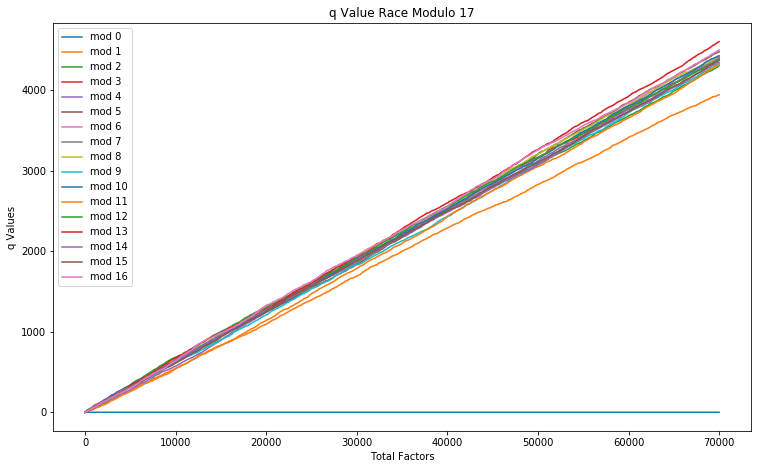

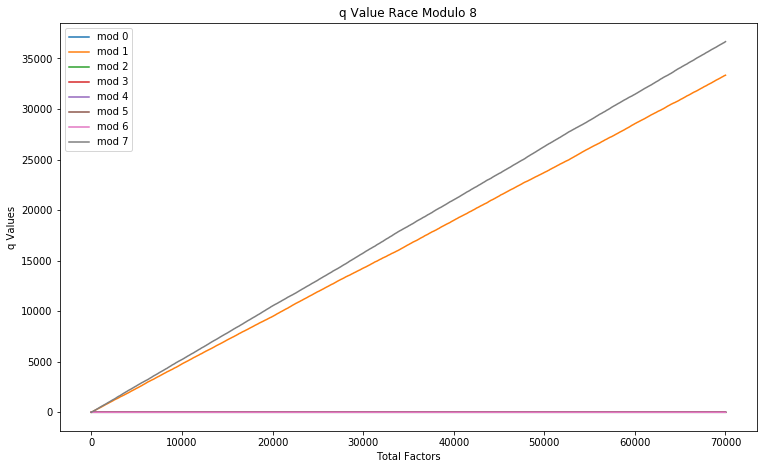

In [7]:
# q line graphs

xq = np.arange(len(qarray)) + 1 # starting the x axis from 1, because I'm not a savage

for m in mod_list:    
    for i in range(m):
        plt.plot(xq, q_races[m][i], label='mod ' + str(i))

    plt.xlabel('Total Factors')
    plt.ylabel('q Values')
    plt.title("q Value Race Modulo " + str(m))
    plt.legend()

    fig = plt.gcf()
    fig.set_size_inches(12.5, 7.5)

    plt.show()

## Bar Graphs of Maxima

If we have high mods, it could be nice just to look at maxima at various endpoints.

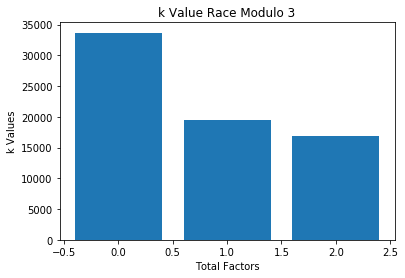

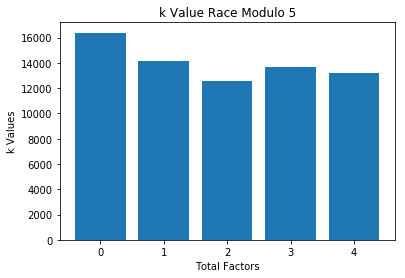

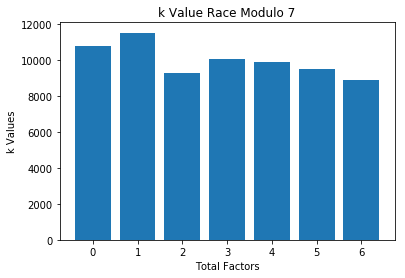

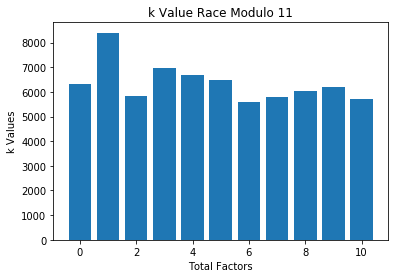

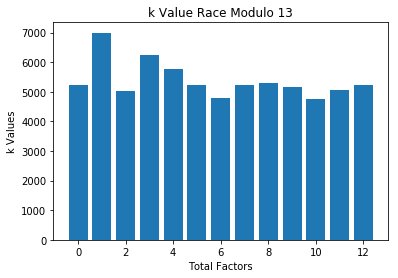

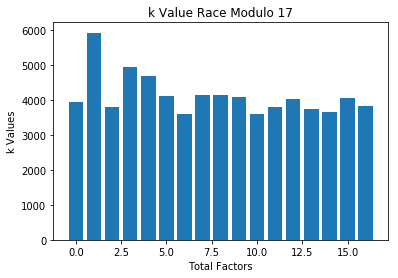

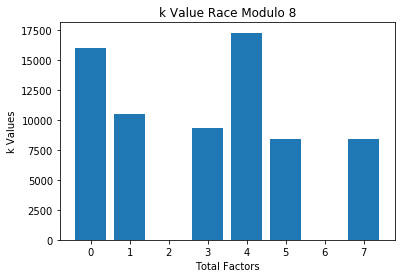

In [11]:
# Bar graphs of maxima, in k

for m in mod_list:
    x = np.arange(m) # a bar for each residue
    y = np.zeros_like(x) # the accumulated values at the end
    
    for i in range(m):
        y[i] = k_races[m][i][lines-1]
    
    plt.bar(x, y)

    plt.xlabel('Total Factors')
    plt.ylabel('k Values')
    plt.title("k Value Race Modulo " + str(m))

    fig = plt.gcf()
    fig.set_size_inches(6, 4)

    plt.show()

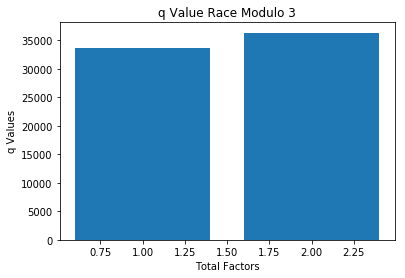

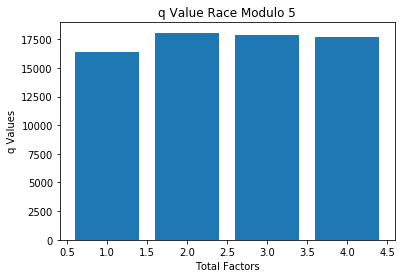

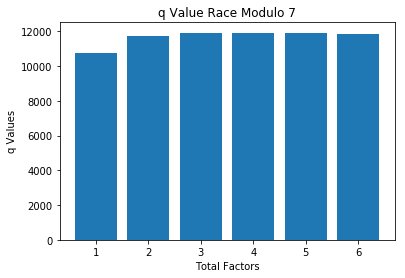

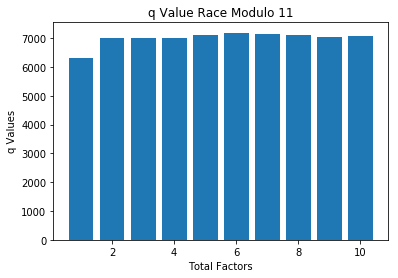

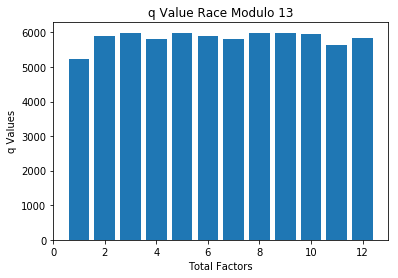

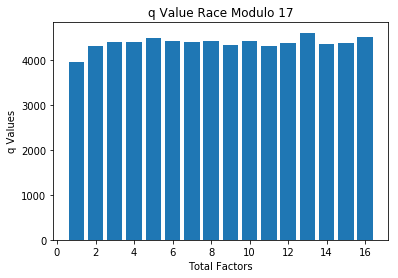

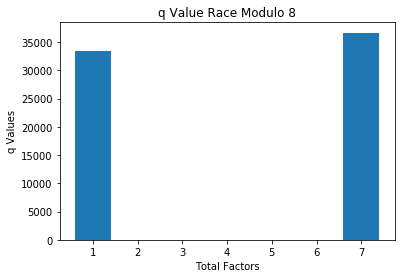

In [16]:
# q part

for m in mod_list:
    x = np.arange(m-1) + 1 # a bar for each residue
    y = np.zeros_like(x) # the accumulated values at the end
    
    for i in x:
        y[i-1] = q_races[m][i][lines-1]
    
    plt.bar(x, y)

    plt.xlabel('Total Factors')
    plt.ylabel('q Values')
    plt.title("q Value Race Modulo " + str(m))

    fig = plt.gcf()
    fig.set_size_inches(6, 4)

    plt.show()

# Analysis

The q values seem much more stable than the k-races, and not just because the k-values get split into groups by q values. There is a noticeable bias against mod 1 in the q data we see; this is interesting, given that we might expect other residues which are solutions of squares (i.e. 4 mod 11 comes from 2 squared) to also perform more weakly.

There's a bit more anarchy in the k races. A given k value corresponds to a given q value via the associated exponent p, except when q has residue 1 (and then k is always zero, and vice versa). Zero seems to lead strongly in the lowest moduli, but this advantage gives out against k mod 1 later.

I don't know why this happens, but it corresponds to a Sophie Germain-like condition modulo m; this is to say, we have $2p+1\equiv q$, reminiscent of the Sophie Germain relation between primes without modular restriction. It's no conjecture that this equation will be true for many combinations of p, q and m all prime but it doesn't seem obvious why they should look so typical here. We [have](https://primes.utm.edu/notes/proofs/MerDiv2.html) that this is well established when $k=1$, rather than just the congruence matching, but perhaps this influence is enough. It seems possible that it's not, and that this is just an artifact of those factors being easier to find.

In the race modulo 8, of interest due to the classical restriction for primes dividing Mersenne numbers, we seem to have an expected Chebyshev-like bias in the primes q and fairly even division among k residues. This can be seen after some modular arithmetic is done to show the correspondence of k and q values. The biases within the larger groupings among k values look pronounced, but it may not be so surprising to see such apparently straight and slightly different lines for this fairly short race.

# Future (including other notebook ideas)

- Extending out much further, into at least the millions of lines. Distant future may include processing into 1G and beyond.
- Check to see how evenly possible residues for k line up with their possible q values (i.e. mod 8, when $p\equiv1$, do we have $k\equiv3$ and $k\equiv7$ equally often here specifically or is there a bias?). Note that this has a fair amount of p involvement, depending on the modulus.
- Check for biases in smallest, largest, etc. values within factorizations.
- Check for biases in products of two or more primes (and k values?).
- Look at how many short races go when we vary m over a large range.
- Eventually, do some real research on analytic arguments.